<a href="https://colab.research.google.com/github/Asgil/ES_test_case/blob/main/EpidemicSound_test_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Epidemic Sound Test Case
##Exploratory analysis of traffic and subscription data to understand the conversion flow.

Hello! In this notebook I will do the exploratory part of the analysis. This analysis aims to improve teams' understanding of the conversion funnel on the epidemicsound.com website, leveraging data from three key tables: traffic, users, and subscriptions.

Given the time frame of 4 hours, in this notebook I focused on answering the main question: "How many visitors convert to users, and then to paying subscribers?". I also explore some of the given dimensions to get a more detailed picture of the conversion rates.
In the last part of the notebook, I describe in detail potential future analysis I could have done with more time.
I also chose to omit some of the exploratory parts from the notebook, where I initially looked at the data, and calculated some of the metrics to keep this notebook more concise.

Please see the [presentation](https://docs.google.com/presentation/d/1-ufDF7RAjVPZXK_H2QS969vyfMwpP4JoMiBuFDWvjPE/edit?usp=sharing) for the summary of key insights, and recommendations that could potentially optimize the subscription conversion process.

##Part 1: Understanding the overall conversion funnel rates.

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [5]:
subscriptions = pd.read_csv('subscriptions.csv')
traffic = pd.read_csv('traffic.csv')
users = pd.read_csv('users.csv')

We want to know the current conversion rates:
- visitors to users
- users to paying subscribers

In [6]:
# Merge users and subscriptions dataframes on 'user_id' to link user details with their subscriptions.
user_subscriptions = pd.merge(users, subscriptions, on='user_id', how='inner')
# Filter the merged dataframe to include only those users who successfully made their first payment.
paid_subscribers = user_subscriptions[user_subscriptions['did_succeed_first_payment'] == True]
# Merge traffic data with all user subscriptions on 'cookie_id' to find traffic that resulted in free subscriptions.
converted_traffic_free = pd.merge(traffic, user_subscriptions, on='cookie_id', how='inner')
# Merge traffic data with paid subscribers on 'cookie_id' to find traffic that resulted in paid subscriptions.
converted_traffic_paid = pd.merge(traffic, paid_subscribers, on='cookie_id', how='inner')

# Calculate the total number of unique visitors from the traffic data.
total_visitors = traffic['cookie_id'].nunique()

# Calculate the number of unique users who converted to free and to paid subscriptions.
unique_converted_users = converted_traffic_free['cookie_id'].nunique()
unique_paid_subscribers = converted_traffic_paid['cookie_id'].nunique()

# Calculate the conversion rate to free and to paid users as a percentage of total visitors.
conversion_rate_free = (unique_converted_users / total_visitors) * 100
conversion_rate_paid = (unique_paid_subscribers / total_visitors) * 100

print(f"Total unique visitors: {total_visitors}")
print(f"Unique converted users (free): {unique_converted_users}")
print(f"Unique paid subscribers: {unique_paid_subscribers}")
print(f"Conversion rate to free users: {conversion_rate_free:.2f}%")
print(f"Conversion rate to paid subscribers from visitors: {conversion_rate_paid:.2f}%")

Total unique visitors: 1410562
Unique converted users (free): 19635
Unique paid subscribers: 8219
Conversion rate to free users: 1.39%
Conversion rate to paid subscribers from visitors: 0.58%


From a total of **1,4m** unique visitors, **1.39%** (19k) converted to free users, indicating a relatively low initial engagement rate.

We have a potential to investigate relevance of marketing materials and landing page packaging to different groups of users, and test changes, which could improve this engagement rate.

Conversion from registered users to paying subscribers seems more promising, being close to **half** of registered users purchase subscription within the same month.  

A follow up analysis and qualitative user research with the 58% registered users who do not succeed first payment could indicate their motivation and needs.

##Part 2: Conversion rates by Country

In [9]:
# Merge traffic data with user subscriptions on the cookie ID to track all traffic that eventually led to a subscription (both free and paid).
converted_traffic_free = pd.merge(traffic, user_subscriptions, on='cookie_id', how='inner')

# Merge traffic data with the paid subscribers on the cookie ID to track all traffic that specifically led to a paid subscription.
converted_traffic_paid = pd.merge(traffic, paid_subscribers, on='cookie_id', how='inner')

# Aggregate the total number of unique visitors by country from the traffic data to get a baseline of total potential user engagement per country.
total_visitors_per_country = traffic.groupby('country_code')['cookie_id'].nunique().reset_index()
total_visitors_per_country.rename(columns={'cookie_id': 'total_traffic'}, inplace=True)

# Aggregate the total number of unique users who converted to free subscriptions by country to measure engagement that led to non-paying user subscriptions.
unique_converted_users_per_country = converted_traffic_free.groupby('country_code')['cookie_id'].nunique().reset_index()
unique_converted_users_per_country.rename(columns={'cookie_id': 'unique_converted_users'}, inplace=True)

# Aggregate the total number of unique users who converted to paid subscriptions by country to measure engagement that led to paying user subscriptions.
unique_paid_subscribers_per_country = converted_traffic_paid.groupby('country_code')['cookie_id'].nunique().reset_index()
unique_paid_subscribers_per_country.rename(columns={'cookie_id': 'unique_paid_subscribers'}, inplace=True)

# Combine the total traffic, free conversions, and paid conversions data into a single DataFrame for easier comparison and calculation of conversion rates.
conversion_rates_by_country = pd.merge(total_visitors_per_country, unique_converted_users_per_country, on='country_code', how='left')
conversion_rates_by_country = pd.merge(conversion_rates_by_country, unique_paid_subscribers_per_country, on='country_code', how='left')

# Calculate the conversion rate to free users as the number of unique converted users divided by the total traffic, multiplied by 100 for percentage.
conversion_rates_by_country['conversion_rate_free'] = (conversion_rates_by_country['unique_converted_users'] / conversion_rates_by_country['total_traffic']) * 100

# Calculate the conversion rate to paid subscribers as the number of unique paid subscribers divided by the total traffic, multiplied by 100 for percentage.
conversion_rates_by_country['conversion_rate_paid'] = (conversion_rates_by_country['unique_paid_subscribers'] / conversion_rates_by_country['total_traffic']) * 100

# Display the DataFrame
conversion_rates_by_country

,country_code,total_traffic,unique_converted_users,unique_paid_subscribers,conversion_rate_free,conversion_rate_paid
0,DE,138445,1628,758,1.175918,0.547510
1,GB,206078,2845,1164,1.380545,0.564835
2,IN,153636,799,198,0.520060,0.128876
3,US,912992,14377,6105,1.574713,0.668681


India has the lowest sign-up (0.52%) and subscription rates (0.13%), suggesting significant opportunities for improving market penetration and conversion strategies in that region.

##Part 3: Conversion rates by Country and Device type.

In [10]:
# Group the traffic data by country and device, counting unique cookie IDs to determine the total number of unique visitors per group.
total_visitors_per_group = traffic.groupby(['country_code', 'device'])['cookie_id'].nunique().reset_index()
total_visitors_per_group.rename(columns={'cookie_id': 'total_traffic'}, inplace=True)

# Group the converted free traffic data by country and device, counting unique cookie IDs to determine the number of unique users who converted to free users.
unique_converted_users_per_group = converted_traffic_free.groupby(['country_code', 'device'])['cookie_id'].nunique().reset_index()
unique_converted_users_per_group.rename(columns={'cookie_id': 'unique_converted_users'}, inplace=True)

# Group the converted paid traffic data by country and device, counting unique cookie IDs to find the number of unique users who became paid subscribers.
unique_paid_subscribers_per_group = converted_traffic_paid.groupby(['country_code', 'device'])['cookie_id'].nunique().reset_index()
unique_paid_subscribers_per_group.rename(columns={'cookie_id': 'unique_paid_subscribers'}, inplace=True)

# Group the converted paid traffic data by country only, counting unique cookie IDs to get the total number of paid subscribers in each country.
total_paid_subscribers_per_group = converted_traffic_paid.groupby(['country_code'])['cookie_id'].nunique().reset_index()
total_paid_subscribers_per_group.rename(columns={'cookie_id': 'total_paid_subscribers'}, inplace=True)

# Merge the total visitors data with the unique converted free users data on both country code and device, using a left join to include all visitor data.
conversion_rates_by_group = pd.merge(total_visitors_per_group, unique_converted_users_per_group, on=['country_code', 'device'], how='left')
# Merge the resulting DataFrame with the unique paid subscribers data, again on both country code and device.
conversion_rates_by_group = pd.merge(conversion_rates_by_group, unique_paid_subscribers_per_group, on=['country_code', 'device'], how='left')
# Merge with the total paid subscribers per country to include this data in the final analysis.
conversion_rates_by_group = pd.merge(conversion_rates_by_group, total_paid_subscribers_per_group, on=['country_code'], how='left')

#Calculate the metrics
conversion_rates_by_group['conversion_rate_free'] = (conversion_rates_by_group['unique_converted_users'] / conversion_rates_by_group['total_traffic']) * 100
conversion_rates_by_group['conversion_rate_paid'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['total_traffic']) * 100
conversion_rates_by_group['conversion_rate_free_to_paid'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['unique_converted_users']) * 100
conversion_rates_by_group['device_customer_percentage'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['total_paid_subscribers']) * 100

#Display the DataFrame
conversion_rates_by_group

,country_code,device,total_traffic,unique_converted_users,unique_paid_subscribers,total_paid_subscribers,conversion_rate_free,conversion_rate_paid,conversion_rate_free_to_paid,device_customer_percentage
0,DE,Desktop,92789,1343,618,758,1.447370,0.666027,46.016381,81.530343
1,DE,Mobile,45675,285,140,758,0.623974,0.306513,49.122807,18.469657
2,GB,Desktop,114661,2394,996,1164,2.087894,0.868648,41.604010,85.567010
3,GB,Mobile,91442,453,168,1164,0.495396,0.183723,37.086093,14.432990
4,IN,Desktop,71597,604,165,198,0.843611,0.230457,27.317881,83.333333
5,IN,Mobile,82105,195,33,198,0.237501,0.040192,16.923077,16.666667
6,US,Desktop,446826,10726,4941,6105,2.400487,1.105800,46.065635,80.933661
7,US,Mobile,466272,3655,1165,6105,0.783877,0.249854,31.874145,19.082719


Desktop visitors have a consistently higher conversion rate than mobile visitors a
cross all countries. Over three times higher (3.29) on average.

In all countries except for Germany Desktop registered users have a higher conversion rate to paying subscribers.
This is an interesting discrepancy to explore, as it may indicate better better mobile offer packaging in Germany, compared to other contries.
Or it could be just a higher propensity of mobile device usage in Germany.



##Part 4: Conversion rate by Country and Subscription plan

In [18]:
# Group the traffic data by country code, count unique cookie IDs to determine the total number of unique visitors per country.
total_visitors_per_group = traffic.groupby(['country_code'])['cookie_id'].nunique().reset_index()
total_visitors_per_group.rename(columns={'cookie_id': 'total_traffic'}, inplace=True)

# Group the free converted traffic data by country code, count unique cookie IDs to find the number of unique users who converted to free users.
unique_converted_users_per_group = converted_traffic_free.groupby(['country_code'])['cookie_id'].nunique().reset_index()
unique_converted_users_per_group.rename(columns={'cookie_id': 'unique_converted_users'}, inplace=True)
# Group the paid converted traffic data by country code and plan, count unique cookie IDs to find the number of unique users who converted to paid subscribers under each plan.
unique_paid_subscribers_per_group = converted_traffic_paid.groupby(['country_code', 'plan',])['cookie_id'].nunique().reset_index()
unique_paid_subscribers_per_group.rename(columns={'cookie_id': 'unique_paid_subscribers'}, inplace=True)
# Group the paid converted traffic data by country code only, count unique cookie IDs to get the total number of paid subscribers in each country.
total_paid_subscribers_per_group = converted_traffic_paid.groupby(['country_code'])['cookie_id'].nunique().reset_index()
total_paid_subscribers_per_group.rename(columns={'cookie_id': 'total_paid_subscribers'}, inplace=True)

# Merge the total visitors data with the unique converted free users data on country code.
conversion_rates_by_group = pd.merge(total_visitors_per_group, unique_converted_users_per_group, on=['country_code'], how='left')
# Merge the resulting DataFrame with the unique paid subscribers data on country code.
conversion_rates_by_group = pd.merge(conversion_rates_by_group, unique_paid_subscribers_per_group, on=['country_code'], how='left')
# Further merge with the total paid subscribers per country data.
conversion_rates_by_group = pd.merge(conversion_rates_by_group, total_paid_subscribers_per_group, on=['country_code'], how='left')

#Calculate conversion rates
conversion_rates_by_group['conversion_rate_free'] = (conversion_rates_by_group['unique_converted_users'] / conversion_rates_by_group['total_traffic']) * 100
conversion_rates_by_group['conversion_rate_paid'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['unique_converted_users']) * 100
conversion_rates_by_group['plan_customer_percentage'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['total_paid_subscribers']) * 100

#Display the relevant columns
conversion_rates_by_group[['country_code', 'plan', 'unique_paid_subscribers', 'total_paid_subscribers', 'conversion_rate_paid', 'plan_customer_percentage']]


,country_code,plan,unique_paid_subscribers,total_paid_subscribers,conversion_rate_paid,plan_customer_percentage
0,DE,commercial,126,758,7.739558,16.622691
1,DE,personal,632,758,38.820639,83.377309
2,GB,commercial,92,1164,3.233743,7.903780
3,GB,personal,1072,1164,37.680141,92.096220
4,IN,commercial,26,198,3.254068,13.131313
5,IN,personal,172,198,21.526909,86.868687
6,US,commercial,550,6105,3.825555,9.009009
7,US,personal,5557,6105,38.652014,91.023751


##Part 5: Unfinished further analysis

In the part below I decided to keep the unfinished analysis, because at this point I started to exceed the given timeframe.
Given more time (and more data, both different tracking data and extended time period) I would have focused on analysing conversion performance over time, looking at seasonality, delayed conversion, impact of marketing campaigns, product improvements, pricing changes, etc.

In [31]:

total_visitors_per_group = traffic.groupby(['country_code'])['cookie_id'].nunique().reset_index()
total_visitors_per_group.rename(columns={'cookie_id': 'total_traffic'}, inplace=True)

unique_converted_users_per_group = converted_traffic_free.groupby(['country_code'])['cookie_id'].nunique().reset_index()
unique_converted_users_per_group.rename(columns={'cookie_id': 'unique_converted_users'}, inplace=True)

unique_paid_subscribers_per_group = converted_traffic_paid.groupby(['country_code', 'plan', 'list_price', 'billing_frequency'])['cookie_id'].nunique().reset_index()
unique_paid_subscribers_per_group.rename(columns={'cookie_id': 'unique_paid_subscribers'}, inplace=True)

total_paid_subscribers_per_group = converted_traffic_paid.groupby(['country_code'])['cookie_id'].nunique().reset_index()
total_paid_subscribers_per_group.rename(columns={'cookie_id': 'total_paid_subscribers'}, inplace=True)

conversion_rates_by_group = pd.merge(total_visitors_per_group, unique_converted_users_per_group, on=['country_code'], how='left')
conversion_rates_by_group = pd.merge(conversion_rates_by_group, unique_paid_subscribers_per_group, on=['country_code'], how='left')
conversion_rates_by_group = pd.merge(conversion_rates_by_group, total_paid_subscribers_per_group, on=['country_code'], how='left')

conversion_rates_by_group['conversion_rate_free'] = (conversion_rates_by_group['unique_converted_users'] / conversion_rates_by_group['total_traffic']) * 100
conversion_rates_by_group['conversion_rate_paid'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['total_traffic']) * 100
conversion_rates_by_group['plan_customer_percentage'] = (conversion_rates_by_group['unique_paid_subscribers'] / conversion_rates_by_group['total_paid_subscribers']) * 100

conversion_rates_by_group[['country_code', 'total_traffic', 'unique_converted_users', 'plan', 'list_price', 'billing_frequency', 'unique_paid_subscribers', 'total_paid_subscribers', 'conversion_rate_free', 'conversion_rate_paid', 'plan_customer_percentage']]


,country_code,total_traffic,unique_converted_users,plan,list_price,billing_frequency,unique_paid_subscribers,total_paid_subscribers,conversion_rate_free,conversion_rate_paid,plan_customer_percentage
0,DE,138445,1628,commercial,20,monthly,43,758,1.175918,0.031059,5.672823
1,DE,138445,1628,commercial,200,yearly,83,758,1.175918,0.059952,10.949868
2,DE,138445,1628,personal,10,monthly,378,758,1.175918,0.273033,49.868074
3,DE,138445,1628,personal,100,yearly,254,758,1.175918,0.183466,33.509235
4,GB,206078,2845,commercial,20,monthly,41,1164,1.380545,0.019895,3.522337
5,GB,206078,2845,commercial,200,yearly,51,1164,1.380545,0.024748,4.381443
6,GB,206078,2845,personal,10,monthly,805,1164,1.380545,0.390629,69.158076
7,GB,206078,2845,personal,100,yearly,267,1164,1.380545,0.129563,22.938144
8,IN,153636,799,commercial,20,monthly,10,198,0.520060,0.006509,5.050505
9,IN,153636,799,commercial,200,yearly,16,198,0.520060,0.010414,8.080808


### Average Time to Convert

In [32]:
def fraction_of_day_to_time(fraction):
    total_seconds = fraction * 86400

    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)

    return f"{hours} hours, {minutes} minutes, {seconds} seconds"

In [33]:
first_visit = traffic.assign(date_day=pd.to_datetime(traffic['date_day'])).groupby('cookie_id').agg(first_visit_date=pd.NamedAgg(column='date_day', aggfunc='min')).reset_index()
user_conversion = pd.merge(users.assign(user_creation_dt=pd.to_datetime(users['user_creation_dt'])), first_visit, on='cookie_id', how='inner')

user_conversion['conversion_delay'] = (user_conversion['user_creation_dt'] - user_conversion['first_visit_date']).dt.days

average_conversion_delay = user_conversion['conversion_delay'].mean()
print(fraction_of_day_to_time(average_conversion_delay))

12 hours, 20 minutes, 4 seconds


###Time-series analysis

In [34]:
#create a df with a count of users created per date
users_per_date = users.groupby('user_creation_dt').size().reset_index(name='user_count')

In [35]:
users_per_date.head()

,user_creation_dt,user_count
0,2023-10-01,1798
1,2023-10-02,1915
2,2023-10-03,1973
3,2023-10-04,1978
4,2023-10-05,1853


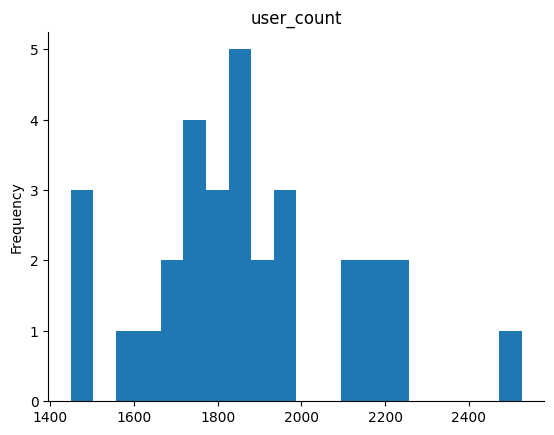

In [36]:
import matplotlib.pyplot as plt
users_per_date['user_count'].plot(kind='hist', bins=20, title='user_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35')])

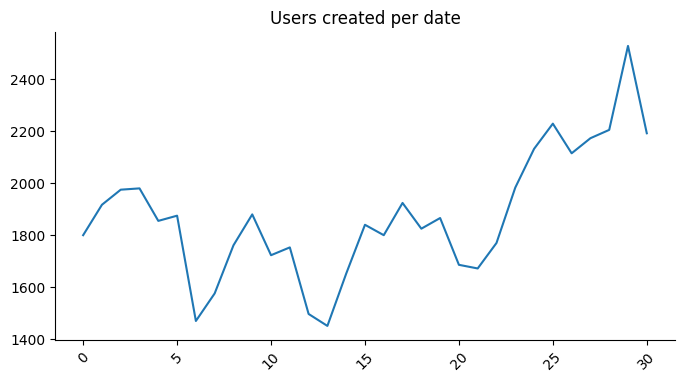

In [37]:
users_per_date['user_count'].plot(kind='line', figsize=(8, 4), title='Users created per date')

plt.gca().spines[['top', 'right']].set_visible(False)
#set x-axis to show dates
plt.xticks(rotation=45)

In [38]:
#Fridays, Saturdays drop in users created
#End of October - some sort of promotion?